## GCM Filters on Irregular Grids with Irregular Filter Scale

This notebook will use data from the idealized one-basin NeverWorld2 configuration performed in MOM6.

We will filter data which is on an irregular grid (hozirontal grid spacing dx varies with latitude, dy is constant).

The filtering scale will be related to the size of the local deformation radius, which is also spatially varying.

In [46]:
%reset
import gcm_filters
import numpy as np
#import cupy as cp
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from dask.diagnostics import ProgressBar
#import cartopy
import cartopy.crs as ccrs
import cmocean
from xgcm import Grid
print('done')

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


done


In [2]:
### Execute the following cell to read in NW2 data for 1/4 (run 20), 1/8 (run 26), or 1/16 (run 28) degree 

In [47]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/

run=20 #1/4 degree 
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [48]:
Nx = np.size(av.xh)
xhp = av.xh
Ny = np.size(av.yh)
yhp = av.yh
print('Nx = %i, Ny = %i' %(Nx,Ny))

Nx = 240, Ny = 560


### The following are the grid types that we have so far implemented in GCM-filters:

In [49]:
list(gcm_filters.GridType)


[<GridType.REGULAR: 1>,
 <GridType.REGULAR_WITH_LAND: 2>,
 <GridType.IRREGULAR_WITH_LAND: 3>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND: 4>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 5>,
 <GridType.VECTOR_C_GRID: 6>]

### To filter with fixed filter length scale, we will use the grid type: IRREGULAR_CARTESIAN_WITH_LAND, and its associated Laplacian. The Laplacian needs the following grid variables:

In [50]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)


['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

In our example, we will filter tracer fields, i.e., fields that are defined at T-points (e.g., h, KE).

(IRREGULAR_CARTESIAN_WITH_LAND could also be used to filter U-fields or V-fields, but we would have to create the filter with different arguments for wet_mask, dxw, dyw, dxs, dys, area.)

wet_mask and area we have directly available from our model output:

In [51]:
wet_mask = fs.wet
area = fs.area_t

# Grid define for computations 
grid = Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'}});
grid

<xgcm.Grid>
X Axis (periodic):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (periodic):
  * center   yh --> outer
  * outer    yq --> center

For the remaining grid variables, recall the following conventions:

dxw = x-spacing centered at western cell edge

dyw = y-spacing centered at western cell edge

dxs = x-spacing centered at southern cell edge

dys = y-spacing centered at southern cell edge

We get these grid variables from our model output as follows:

In [52]:
dxw = xr.DataArray(data=fs.dxCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dyw = xr.DataArray(data=fs.dyCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dxs = xr.DataArray(data=fs.dxCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dys = xr.DataArray(data=fs.dyCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))

In [53]:
Ld = xr.DataArray(av.Rd1.mean(dim='time'))

#Ld[240:320,:]=np.nan #1/4 degree 280 is center, 1120 for 1/16 800:1440, 1600:2880 for 1/32
Ld = Ld.fillna(np.nanmax(Ld))
Ld[0:60,:]=20000
Ld[520:560,:]=38000
fscale = (Ld.mean('xh'))*5; fscale[200:360]=500000.
fscale = 0.*Ld+fscale

print(np.nanmin(Ld),np.nanmax(Ld))
print(Ld)

234.31934 445500.75
<xarray.DataArray 'Rd1' (yh: 560, xh: 240)>
array([[20000., 20000., 20000., ..., 20000., 20000., 20000.],
       [20000., 20000., 20000., ..., 20000., 20000., 20000.],
       [20000., 20000., 20000., ..., 20000., 20000., 20000.],
       ...,
       [38000., 38000., 38000., ..., 38000., 38000., 38000.],
       [38000., 38000., 38000., ..., 38000., 38000., 38000.],
       [38000., 38000., 38000., ..., 38000., 38000., 38000.]],
      dtype=float32)
Coordinates:
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88


/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


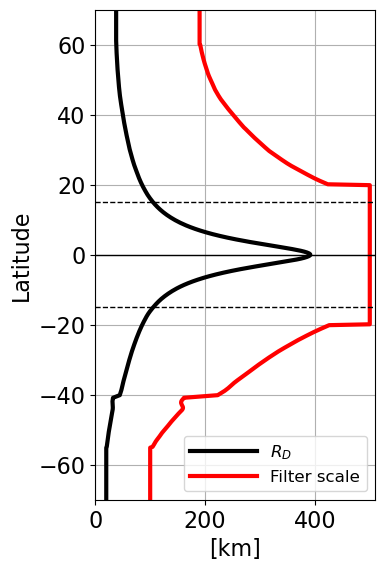

In [57]:
fig = plt.figure(figsize=(4, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.7,0.7]) 

ax1.set_xlabel('[km]',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

ax1.plot(Ld.mean('xh')/1000,yhp,'k',linewidth=3)
ax1.plot(fscale.mean('xh')/1000,yhp,'r',linewidth=3)

ax1.plot([0,1000],[0,0],'k',linewidth=1)
ax1.plot([0,1000],[15,15],'--k',linewidth=1)
ax1.plot([0,1000],[-15,-15],'--k',linewidth=1)

ax1.set_xlim([0,510])
ax1.set_ylim([-70,70])
ax1.grid('on')
plt.legend(['$R_D$','Filter scale'],loc='lower right',fontsize=12,handlelength=4)
plt.show()

The filter needs to know what the minimum grid spacing is in our model.

In [58]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_max = max(dxw.max(),dyw.max(),dxs.max(),dys.max())

dx_min = dx_min.values
dx_max = dx_max.values
dx_min, dx_max

(array(9518.17259783), array(27829.27492305))

In our example, we either choose the (fixed) filter scale to be 100km or make the filter scale a function of the local deformation radius Ld. In the latter case we have kappa_w and kappa_s as scaling factors ranging from 0-1 and the filter scale itself as the maximum deformation radius (not considering regions between 20N and 20S latitude). Note that we need: filter_scale >= dx_min.

In [59]:
#Option 1 using fixed filter scale:

# filter_scale = 500000
# kappa_w = Ld*0.+1. #using kappa_w and kappa_s = 1s recovers the fixed filter scale.
# kappa_s = Ld*0.+1.

#Option 2 using local deformation radius as the filter scale:

# Lf = np.max(Ld.data)
# filter_scale = Lf*10
# kappa_w = Ld**2 / Lf**2
# kappa_s = Ld**2 / Lf**2

#Option 3:coming up with my own filter scale that's a function of zonally averaged Ld*5, 500km near equator

Lf = np.max(fscale.data)
filter_scale = Lf
kappa_w = fscale**2 / Lf**2
kappa_s = fscale**2 / Lf**2

In [60]:
print(kappa_w.shape)

(560, 240)


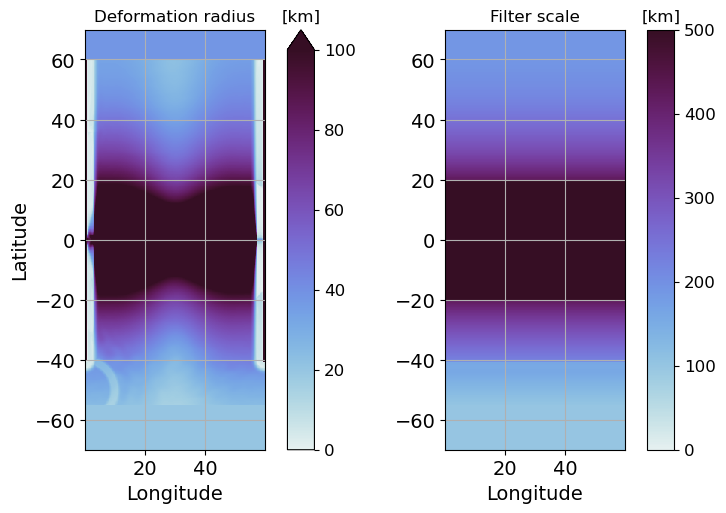

In [61]:
#Plotting Filter scale
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.35,0.7]) 
axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.55,0.2,0.35,0.7]) 
axc2 = fig.add_axes([.85, 0.2, 0.03, 0.7])

ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Deformation radius',fontsize=12)
ax2.set_title('Filter scale',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)


plotted1 =ax1.pcolormesh(xhp,yhp,Ld/1000,cmap=cmocean.cm.dense,vmin=0,vmax=100)
plotted2 =ax2.pcolormesh(xhp,yhp,filter_scale*(kappa_s**0.5)/1000,cmap=cmocean.cm.dense,vmin=0,vmax=500)


ax1.set_aspect('equal', 'box'); ax2.set_aspect('equal', 'box')
ax1.grid('on'); ax2.grid('on')

cbar1 = plt.colorbar(mappable=plotted1, cax=axc1, orientation = 'vertical',extend='max');
cbar2 = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');

cbar1.ax.tick_params(labelsize=12); cbar2.ax.tick_params(labelsize=12);
axc1.set_title('[km]'); axc2.set_title('[km]')

#
plt.show()

In [62]:
print(area)

<xarray.DataArray 'area_t' (yh: 560, xh: 240)>
[134400 values with dtype=float64]
Coordinates:
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
Attributes:
    long_name:     Surface area of tracer (T) cells
    units:         m2
    cell_methods:  area:sum yh:sum xh:sum time: point


### Defining the filter:

In [63]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    transition_width=2*np.pi,
    n_steps=70, #default value is 50, 0 chooses automatically
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 
               'area': area, 'kappa_w': kappa_w, 'kappa_s': kappa_s}
)
filter

n_steps = 70


Filter(filter_scale=500000.0, dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=6.283185307179586, ndim=2, n_steps=70, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

### Interpolating the velocities onto thickness points:

In [64]:
%%time

#u_interp and v_interp are the unfiltered velocities we will work with below. 
ufull = av.u[:,:,:,:]; 
u_interp= grid.interp(ufull,axis='X')#.fillna(0.) 

vfull = av.v[:,:,:,:];
v_interp=grid.interp(vfull,axis='Y')#.fillna(0.) 

h = (av.h[:,:,:,:]).mean(dim='time')#.fillna(0.)
depth=fs.depth_ocean

print('done')

done
CPU times: user 3.97 s, sys: 3.36 s, total: 7.33 s
Wall time: 35.4 s


/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### First applying the filter to compute mean and BT/BC mean (those two sum to mean) velocities at each time step
### At the end, average all components so that the mean has the spatial filter and temporal averaging applied.

In [65]:
%%time
u_mean=0.0*u_interp; u_eddy = 0.0*u_interp
v_mean=0.0*v_interp; v_eddy = 0.0*v_interp
u_BT_mean=0.0*u_interp[:,0,:,:]; v_BT_mean=0.0*u_interp[:,0,:,:]
u_BC_mean=0.0*u_interp; v_BC_mean=0.0*u_interp
#u_interp and v_interp are the unfiltered velocities

for i in range(0,100): #100 5-day averages, so total 500 day span
    print(i)
    u_mean[i,:,:,:] = (filter.apply(u_interp[i,:,:,:], dims=['yh', 'xh'])).fillna(0.)  #3D field in space
    u_BT_mean[i,:,:] = (u_mean[i,:,:,:]*h/depth).sum('zl')                           #2D field in space
    u_BC_mean[i,:,:,:] = (u_mean[i,:,:,:]-u_BT_mean[i,:,:])                          #3D field in space

    v_mean[i,:,:,:] = (filter.apply(v_interp[i,:,:,:], dims=['yh', 'xh'])).fillna(0.) 
    v_BT_mean[i,:,:] = (v_mean[i,:,:,:]*h/depth).sum('zl')
    v_BC_mean[i,:,:,:] = (v_mean[i,:,:,:]-v_BT_mean[i,:,:])


u_eddy = (u_interp-u_mean).fillna(0.) ; #
v_eddy = (v_interp-v_mean).fillna(0.) ; #


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 13min, sys: 1min 47s, total: 14min 48s
Wall time: 14min 48s


In [70]:
u_BC_mean.shape

(100, 15, 560, 240)

In [71]:
v_mean.shape

(100, 15, 560, 240)

### Now we compute the eddy components and then the KE corresponding to mean/eddy/BT/BC parts.

In [72]:
KE_BT_eddy=xr.zeros_like(u_interp[:,0,:,:])
KE_BC_eddy=xr.zeros_like(u_interp[:,0,:,:])

KE_BT_mean=xr.zeros_like(u_interp[:,0,:,:]) #
KE_BC_mean=xr.zeros_like(u_interp[:,0,:,:]) #

#For the modified filter where we add stationary small scales to mean:
    ####
stationary_small_u = u_eddy.mean('time')
stationary_small_v = v_eddy.mean('time')
for i in range(0,100):
    u_eddy[i,:,:,:] = u_eddy[i,:,:,:]-stationary_small_u
    u_BT_mean[i,:,:] = ((u_mean[i,:,:,:]+stationary_small_u)*h/depth).sum('zl')                           #2D field in space
    u_BC_mean[i,:,:,:] = ((u_mean[i,:,:,:]+stationary_small_u)-u_BT_mean[i,:,:])                          #3D field in space

    v_eddy[i,:,:,:] = v_eddy[i,:,:,:]-stationary_small_v
    v_BT_mean[i,:,:] = ((v_mean[i,:,:,:]+stationary_small_v)*h/depth).sum('zl')
    v_BC_mean[i,:,:,:] = ((v_mean[i,:,:,:]+stationary_small_v)-v_BT_mean[i,:,:])

    
    u_BT_eddy = (u_eddy[i,:,:,:]*h/depth).sum('zl')
    u_BC_eddy = (u_eddy[i,:,:,:]-u_BT_eddy)

    v_BT_eddy = (v_eddy[i,:,:,:]*h/depth).sum('zl')
    v_BC_eddy = (v_eddy[i,:,:,:]-v_BT_eddy)
        
    KE_BT_eddy[i,:,:] = 0.5*(u_BT_eddy**2+v_BT_eddy**2)
    KE_BC_eddy[i,:,:] = (0.5*(u_BC_eddy**2+v_BC_eddy**2)*h/depth).sum('zl')

    KE_BT_mean[i,:,:] = 0.5*(u_BT_mean[i,:,:]**2+v_BT_mean[i,:,:]**2)  #
    KE_BC_mean[i,:,:] = (0.5*(u_BC_mean[i,:,:,:]**2+v_BC_mean[i,:,:,:]**2)*h/depth).sum('zl')  #
    
#KE_BT_mean = 0.5*(u_BT_mean**2+v_BT_mean**2)  #
#KE_BC_mean = (0.5*(u_BC_mean**2+v_BC_mean**2)*h/depth).sum('zl')  #
    
KE_mean = KE_BT_mean+KE_BC_mean
KE_eddy = KE_BT_eddy+KE_BC_eddy
KE_BT   = KE_BT_mean+KE_BT_eddy
KE_BC   = KE_BC_mean+KE_BC_eddy

KE_TOT = KE_BT+KE_BC

KE_filtered   = 0.5*(u_mean**2+v_mean**2)
KE_unfiltered = 0.5*(u_interp**2+v_interp**2)

print('done but KE values still need to be averaged in time')

done but KE values still need to be averaged in time


In [73]:
KE_TOT.shape

(100, 560, 240)

### Plotting results:

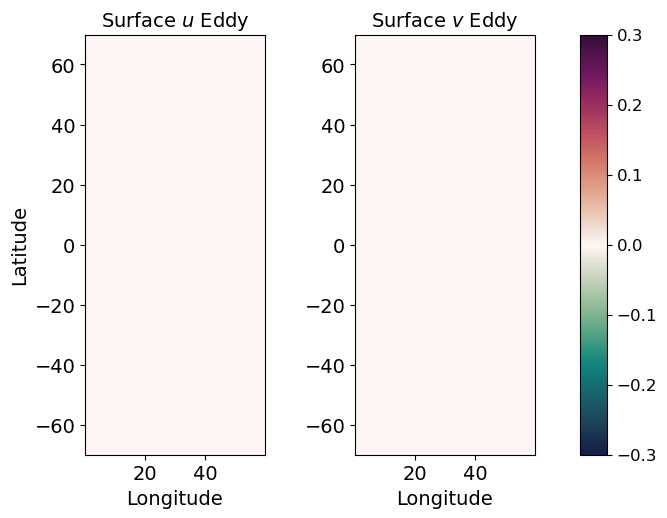

In [74]:

#Plotting eddy/mean velocities for whole domain
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) 
#axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.45,0.2,0.3,0.7]) 
axc2 = fig.add_axes([.75, 0.2, 0.03, 0.7])


ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)


ax1.set_title('Surface $u$ Eddy',fontsize=14)
ax2.set_title('Surface $v$ Eddy',fontsize=14)

plotted1 =ax1.pcolorfast(xhp,yhp,u_eddy[:,0,:,:].mean('time'),cmap=cmocean.cm.curl,vmin=-.3,vmax=.3)
plotted2 =ax2.pcolorfast(xhp,yhp,v_eddy[:,0,:,:].mean('time'),cmap=cmocean.cm.curl,vmin=-.3,vmax=.3)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax.set_title('m/s')
# # #
# plt.clf()


Text(0.5, 1.0, '[1/s]')

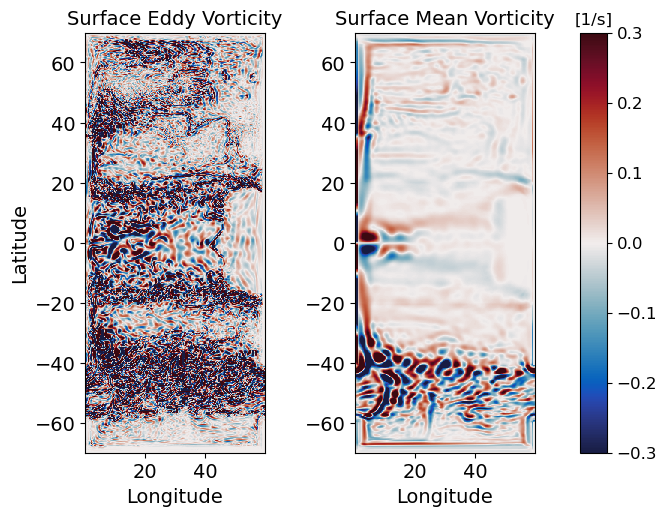

In [75]:
#Plotting eddy/mean vorticities
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) 
#axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.45,0.2,0.3,0.7]) 
axc2 = fig.add_axes([.75, 0.2, 0.03, 0.7])


ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)


ax1.set_title('Surface Eddy Vorticity',fontsize=14)
ax2.set_title('Surface Mean Vorticity',fontsize=14)

eddy_vorticity_sn = (v_eddy[-1,0,:,:]).differentiate('xh')-(u_eddy[-1,0,:,:]).differentiate('yh')
eddy_vorticity_m = ((v_eddy[:,0,:,:]).differentiate('xh')-(u_eddy[:,0,:,:]).differentiate('yh')).mean('time')

mean_vorticity = ((v_mean[:,0,:,:]).differentiate('xh')-(u_mean[:,0,:,:]).differentiate('yh')).mean('time')

plotted1 =ax1.pcolorfast(xhp,yhp,eddy_vorticity_sn,cmap=cmocean.cm.balance,vmin=-.3,vmax=.3)
plotted2 =ax2.pcolorfast(xhp,yhp,mean_vorticity,cmap=cmocean.cm.balance,vmin=-.3,vmax=.3)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
cbar.ax.set_title('[1/s]')
# # #
# plt.clf()

In [32]:
v_mean

<xarray.DataArray (time: 100, zl: 15, yh: 560, xh: 240)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0.,

In [26]:
np.max(eddy_vorticity)
print(eddy_vorticity)

<xarray.DataArray (yh: 560, xh: 240)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     float64 3.05e+04
    zl       float64 1.023e+03
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88


In [37]:
test = v_eddy[0,0,:,:].differentiate('xh')
np.max(test)

<xarray.DataArray ()>
array(1.79570162)
Coordinates:
    time     float64 3e+04
    zl       float64 1.023e+03

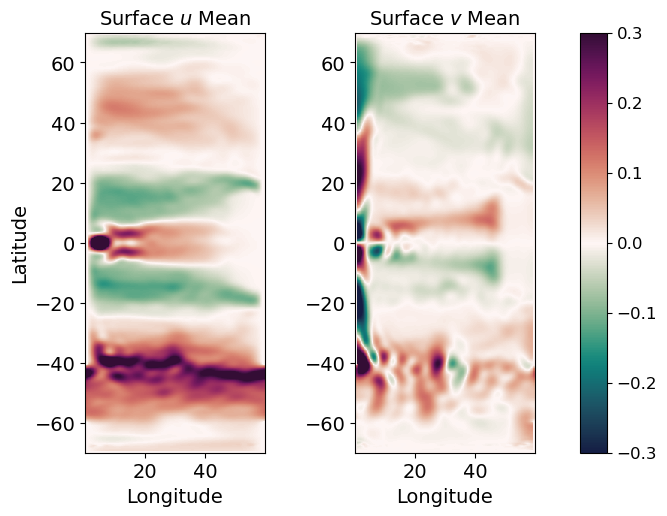

In [26]:
#Plotting filtered (mean) velocities for whole domain
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) 
#axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.45,0.2,0.3,0.7]) 
axc2 = fig.add_axes([.75, 0.2, 0.03, 0.7])

ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)



ax1.set_title('Surface $u$ Mean',fontsize=14)
ax2.set_title('Surface $v$ Mean',fontsize=14)
#var = KEfull_filtered[0,:,:]
#var[200:360,:]=np.nan

plotted1 =ax1.pcolor(xhp,yhp,u_mean[:,0,:,:].mean('time'),cmap=cmocean.cm.curl,vmin=-.3,vmax=.3)
plotted2 =ax2.pcolor(xhp,yhp,(v_mean[:,0,:,:]).mean('time'),cmap=cmocean.cm.curl,vmin=-.3,vmax=.3)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax.set_title('m/s')
#
plt.show()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


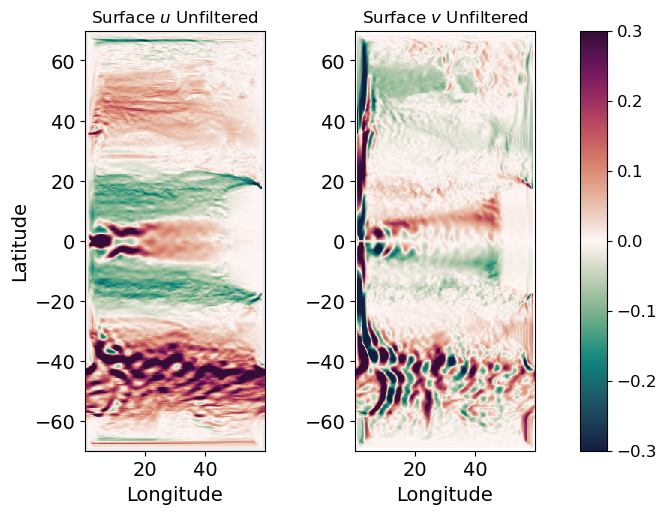

In [50]:
#Plotting unfiltered velocities for whole domain
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) 
#axc1 = fig.add_axes([0.45,0.2,0.03,0.7])
ax2 = fig.add_axes([0.45,0.2,0.3,0.7]) 
axc2 = fig.add_axes([.75, 0.2, 0.03, 0.7])

ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=14); ax2.set_xlabel('Longitude',fontsize=14)
ax1.set_ylabel('Latitude',fontsize=14)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)

levels=np.linspace(-5,0,11)

ax1.set_title('Surface $u$ Unfiltered',fontsize=12)
ax2.set_title('Surface $v$ Unfiltered',fontsize=12)
#var = KEfull_filtered[0,:,:]
#var[200:360,:]=np.nan

plotted1 =ax1.pcolorfast(xhp,yhp,np.nanmean(u_interp[:,0,:,:],axis=0),cmap=cmocean.cm.curl,vmin=-0.3,vmax=0.3)
plotted2 =ax2.pcolorfast(xhp,yhp,np.nanmean(v_interp[:,0,:,:],axis=0),cmap=cmocean.cm.curl,vmin=-0.3,vmax=0.3)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

cbar = plt.colorbar(mappable=plotted2, cax=axc2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax.set_title('m/s')
#
plt.show()

In [29]:
KE_eddy.shape

(100, 560, 240)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


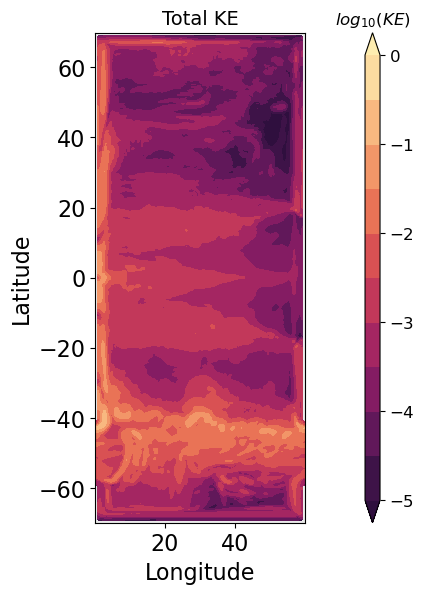

In [76]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

levels=np.linspace(-5,0,11)

#ax1.set_title('Surface KE Unfiltered',fontsize=14)
#var = KEfull[0,:,:]
ax1.set_title('Total KE',fontsize=14)
var = abs(KE_TOT).mean('time')
#var[200:360,:]=np.nan

plotted =ax1.contourf(xhp,yhp,(np.log10(var)),levels=levels,cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


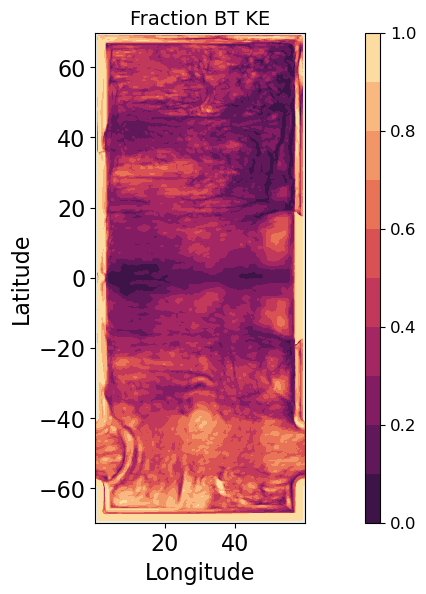

In [27]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

levels=np.linspace(0,1.,11)

#ax1.set_title('Surface KE Unfiltered',fontsize=14)
var = (KE_BT/(KE_BT+KE_BC)).mean('time')
ax1.set_title('Fraction BT KE',fontsize=14)
#var[200:360,:]=np.nan

plotted =ax1.contourf(xhp,yhp,var,levels=levels,cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

Text(0.5, 1.0, '1/4$^\\circ$ KE Fractions')

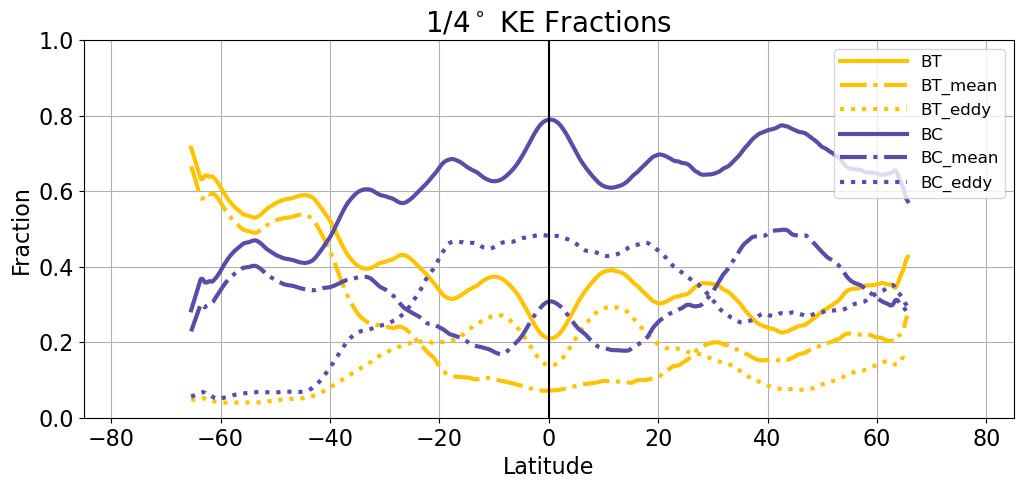

In [43]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yhp,np.convolve((KE_BT/(KE_BT+KE_BC)).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)
plt.plot(yhp,np.convolve((KE_BT_mean/(KE_BT+KE_BC)).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),'-.',c='#FFC300',linewidth=3)
plt.plot(yhp,np.convolve((KE_BT_eddy/(KE_BT+KE_BC)).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),':',c='#FFC300',linewidth=3)
plt.grid()
plt.plot(yhp,np.convolve((KE_BC/(KE_BT+KE_BC)).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.plot(yhp,np.convolve((KE_BC_mean/(KE_BT+KE_BC)).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),'-.',c='#584EA7',linewidth=3)
plt.plot(yhp,np.convolve((KE_BC_eddy/(KE_BT+KE_BC)).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),':',c='#584EA7',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BT_mean+fraction_BT_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BC_mean+fraction_BC_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)

plt.legend(['BT','BT_mean','BT_eddy','BC','BC_mean','BC_eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/4$^\circ$ KE Fractions',fontsize=20)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, '1/4$^\\circ$ KE Fractions')

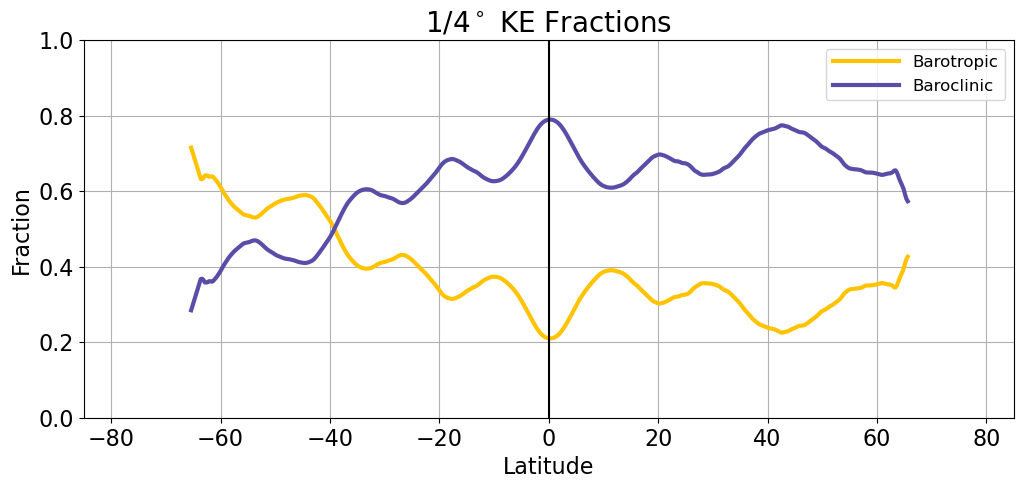

In [45]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yhp,np.convolve((KE_BT/(KE_BT+KE_BC)).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)
plt.grid()
plt.plot(yhp,np.convolve((KE_BC/(KE_BT+KE_BC)).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BT_mean+fraction_BT_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BC_mean+fraction_BC_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)

plt.legend(['Barotropic','Baroclinic'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/4$^\circ$ KE Fractions',fontsize=20)

Text(0.5, 1.0, '1/4$^\\circ$ KE Values')

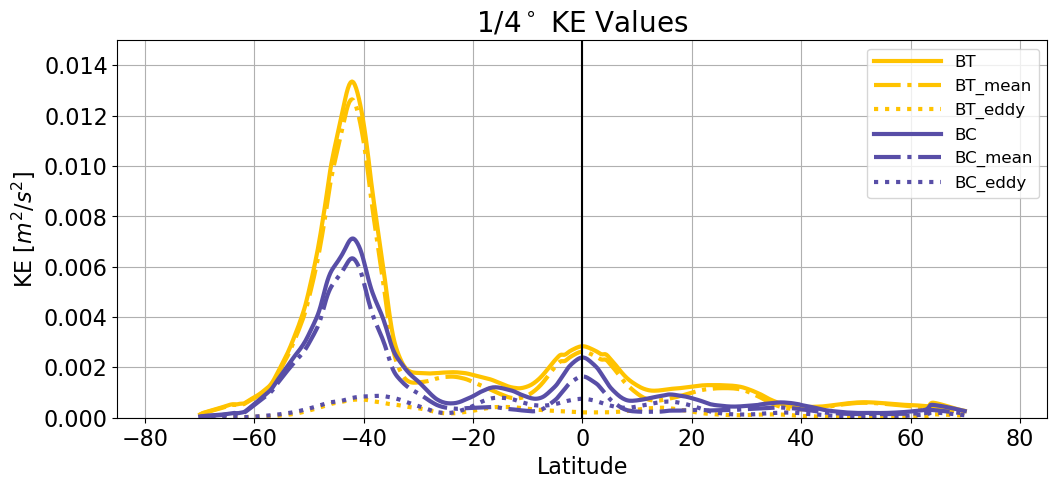

In [42]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yhp,np.convolve((KE_BT).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)
plt.plot(yhp,np.convolve((KE_BT_mean).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),'-.',c='#FFC300',linewidth=3)
plt.plot(yhp,np.convolve((KE_BT_eddy).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),':',c='#FFC300',linewidth=3)
plt.grid()
plt.plot(yhp,np.convolve((KE_BC).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.plot(yhp,np.convolve((KE_BC_mean).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),'-.',c='#584EA7',linewidth=3)
plt.plot(yhp,np.convolve((KE_BC_eddy).mean('time').mean('xh'), np.ones((window,))/window, mode='same'),':',c='#584EA7',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BT_mean+fraction_BT_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BC_mean+fraction_BC_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)

plt.legend(['BT','BT_mean','BT_eddy','BC','BC_mean','BC_eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85); plt.xticks(fontsize=16);
plt.ylim(0,0.015); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('KE [$m^2/s^2$]',fontsize=16)
plt.title('1/4$^\circ$ KE Values',fontsize=20)